## QUERY

In [1]:
# usage example (the mysql detail already defined)
# simple query
query_order_design = """
SELECT
  order_design.id_order AS id_order_design,
  order_design.id_user,
  order_design.id_designer,
  promo_code.code ,
  order_design.status AS status_design,
  order_design.address,
  address_components.address_componentable_id ,
  CAST(address_components.latitude AS FLOAT) AS lat,
  CAST(address_components.longitude AS FLOAT) AS lng,
  order_design.created_at AS order_date
FROM
  order_design 
  LEFT JOIN detail_order_design ON detail_order_design.id_order = order_design.id_order
  LEFT JOIN promo_code ON order_design.id_promo = promo_code.id_promo
  JOIN address_components ON order_design.id_order = address_components.address_componentable_id
  LEFT JOIN user ON order_design.id_user = user.id_user
WHERE
    ((order_design.status <> 'expired')
    OR (order_design.status IS NULL))
  	AND address_components.address_componentable_type LIKE '%OrderDesign'
GROUP BY
  order_design.id_order,
  order_design.id_user,
  order_design.id_designer,
  order_design.id_promo ,
  order_design.address,
  order_design.status,
  address_components.address_componentable_id ,
  address_components.latitude,
  address_components.longitude,
  order_design.created_at
"""

## Import Function

In [2]:
from functions.database_load import *
from functions.cleaning import * 
from functions.utils import *
from functions.clustering import *
from functions.neighbors import *
from functions.visualization import *

#### Reload/ update function

In [3]:
# from importlib import reload
# import functions.utils
# reload(functions.utils)

## Mengambil Data Order Design

In [4]:
# fetch data
df_od = fetch_data(query_order_design)

In [5]:
df_od.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_order_design           199 non-null    int64         
 1   id_user                   199 non-null    int64         
 2   id_designer               185 non-null    float64       
 3   code                      189 non-null    object        
 4   status_design             199 non-null    object        
 5   address                   199 non-null    object        
 6   address_componentable_id  199 non-null    int64         
 7   lat                       199 non-null    float64       
 8   lng                       199 non-null    float64       
 9   order_date                199 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 15.7+ KB


### Menghapus data id yang tidak terpakai 

In [6]:
#  menghapus id yang tidak terpakai untuk analisis
ids_to_remove= [887]
df_od_new = remove_ids_from_dataframe(df_od, column_name="id_order_design", ids_to_remove=ids_to_remove)

## Missing Values

In [7]:
#  cek missing values
cek_missing_values(df_od_new)

id_order_design              0
id_user                      0
id_designer                 14
code                        10
status_design                0
address                      0
address_componentable_id     0
lat                          0
lng                          0
order_date                   0
dtype: int64

In [8]:
# input code promo yang null dengan nilai N/A
fill_missing_values(df_od_new, column_name="code", fill_value="N/A").head()

,id_order_design,id_user,id_designer,code,status_design,address,address_componentable_id,lat,lng,order_date
0,568,921,949.0,PREBUILD50,in_review,"Emerald View, Jln. Emerald Citra V, Blok D no....",568,-6.28352,106.711,2024-04-20 15:28:15
1,569,923,950.0,PREBUILD50,in_review,"Perumahan Jatinegara Indah, Jl Lawu Ujung Blok...",569,-6.19922,106.927,2024-04-21 10:30:22
2,570,925,943.0,PREBUILD50,finish,"Premier Terrace Blok M3, Jalan Raya Ciracas, C...",570,-6.32984,106.876,2024-04-21 16:00:33
3,571,926,946.0,PREBUILD50,in_review,"Mahagoni Park Bintaro Blok B1 No 50, Perigi Ba...",571,-6.26076,106.690,2024-04-22 10:25:36
4,572,927,928.0,N/A,finish,Jl. Ujung Gedong RT 002 RW 012 no.69 Kel. Gedo...,572,-6.29776,106.862,2024-04-22 11:41:42


In [9]:
#  preprocess data (drop missing values)
df_od_clean=preprocess_data(df_od_new)

In [10]:
# Split numeric and object data
df_od_num = df_od_clean.select_dtypes(include=['int64', 'float64'])

In [11]:
# find outliers
for col in df_od_num:
        values = df_od_num[col].sort_values().values.tolist()
        outliers = find_outlier(values)
        outlier_count = len(outliers.split(', ')) - 1  # Split string and count
        outlier_percent = (outlier_count / len(values)) * 100
        print(f"Outliers detected in '{col}': {outlier_count} ({outlier_percent:.2f}%)")

Outliers detected in 'id_order_design': 0 (0.00%)
Outliers detected in 'id_user': 0 (0.00%)
Outliers detected in 'id_designer': 32 (17.39%)
Outliers detected in 'address_componentable_id': 0 (0.00%)
Outliers detected in 'lat': 36 (19.57%)
Outliers detected in 'lng': 33 (17.93%)


## Clustering Order Design

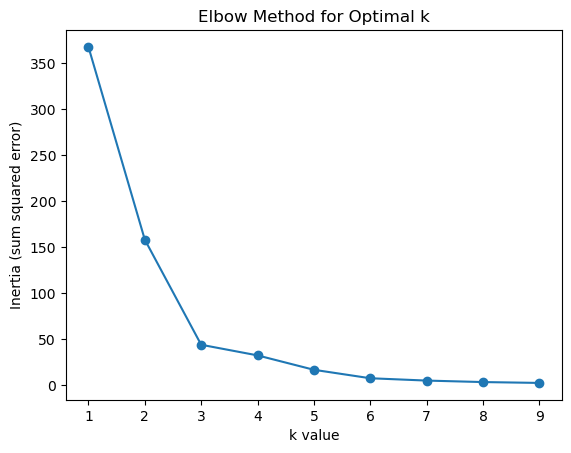

Inertia values for k=1 to 9: [368.0, 158.37404505516992, 44.075180832769256, 32.5196161564615, 16.85156273026178, 7.651772535766982, 5.117820020404313, 3.5048234275619743, 2.570444416797133]


In [12]:
# tentukan kolom untuk cluster
feature_cols = ['lat', 'lng']
# Hitung inertia
inertia_values = calculate_inertia(df_od_clean, feature_cols)

# print inertia
print("Inertia values for k=1 to 9:", inertia_values)

In [13]:
# menentukan cluster dan menambahkan kolom cluster pada data order garden care
perform_clustering(df_od_clean, feature_cols, n_clusters=5, max_iter=1000)

,id_order_design,id_user,id_designer,code,status_design,address,address_componentable_id,lat,lng,order_date,cluster
0,568,921,949.0,PREBUILD50,in_review,"Emerald View, Jln. Emerald Citra V, Blok D no....",568,-6.28352,106.7110,2024-04-20 15:28:15,0
1,569,923,950.0,PREBUILD50,in_review,"Perumahan Jatinegara Indah, Jl Lawu Ujung Blok...",569,-6.19922,106.9270,2024-04-21 10:30:22,0
2,570,925,943.0,PREBUILD50,finish,"Premier Terrace Blok M3, Jalan Raya Ciracas, C...",570,-6.32984,106.8760,2024-04-21 16:00:33,0
3,571,926,946.0,PREBUILD50,in_review,"Mahagoni Park Bintaro Blok B1 No 50, Perigi Ba...",571,-6.26076,106.6900,2024-04-22 10:25:36,0
4,572,927,928.0,N/A,finish,Jl. Ujung Gedong RT 002 RW 012 no.69 Kel. Gedo...,572,-6.29776,106.8620,2024-04-22 11:41:42,0
...,...,...,...,...,...,...,...,...,...,...,...
192,911,1681,931.0,freesurvey,in_review_internal,Bumi Cimanggi Indah Blok A6 no.20 kel.sukatani...,911,-6.38782,106.8760,2024-09-18 16:10:26,0
193,912,1641,1301.0,freesurvey,in_review,"BSD City Cluster Sevilla CB17 Serpong, Tangsel...",912,-6.31722,106.6920,2024-09-19 10:38:36,0
194,914,1686,982.0,freesurvey,finish,"Jl. Rambutan No.12A CONDET, Kel. Cililitan, Ke...",914,-6.25960,106.8690,2024-09-21 09:44:30,0
195,915,1485,948.0,freesurvey,on_going,"Madirsan,tanjung Morawa, Kabupaten Deli Serdan...",915,3.53093,98.7633,2024-09-21 16:23:20,1


In [14]:
calculate_nearest_neighbors(
    df_od_clean,
    lat_col='lat',        # Nama kolom latitude
    lng_col='lng',        # Nama kolom longitude
    id_col='id_order_design',          # Nama kolom ID unik
    n_neighbors=3,        # Jumlah tetangga terdekat
    max_distance=10000    # Jarak maksimum dalam meter
)

,id_order_design,id_user,id_designer,code,status_design,address,address_componentable_id,lat,lng,order_date,cluster,neighbors,neighbor_distances,valid_neighbors,valid_distances
0,568,921,949.0,PREBUILD50,in_review,"Emerald View, Jln. Emerald Citra V, Blok D no....",568,-6.28352,106.7110,2024-04-20 15:28:15,0,"[674, 641, 568]","[0.0, 0.0, 0.0]","[674, 641, 568]","[0.0, 0.0, 0.0]"
1,569,923,950.0,PREBUILD50,in_review,"Perumahan Jatinegara Indah, Jl Lawu Ujung Blok...",569,-6.19922,106.9270,2024-04-21 10:30:22,0,"[569, 663, 839]","[0.0, 0.029463088772227138, 0.03904377543219883]","[569, 663, 839]","[0.0, 3258.7180589049435, 4317.821106738846]"
2,570,925,943.0,PREBUILD50,finish,"Premier Terrace Blok M3, Jalan Raya Ciracas, C...",570,-6.32984,106.8760,2024-04-21 16:00:33,0,"[570, 636, 572]","[0.0, 0.03386704740599568, 0.03500180566771175]","[570, 636, 572]","[0.0, 3745.309286065119, 3871.1113548546737]"
3,571,926,946.0,PREBUILD50,in_review,"Mahagoni Park Bintaro Blok B1 No 50, Perigi Ba...",571,-6.26076,106.6900,2024-04-22 10:25:36,0,"[571, 865, 646]","[0.0, 0.00457192519623849, 0.008526576100635307]","[571, 865, 646]","[0.0, 505.73972627959273, 943.4743886329433]"
4,572,927,928.0,N/A,finish,Jl. Ujung Gedong RT 002 RW 012 no.69 Kel. Gedo...,572,-6.29776,106.8620,2024-04-22 11:41:42,0,"[572, 608, 650]","[0.0, 0.02196235187770273, 0.028981897798445348]","[572, 608, 650]","[0.0, 2430.073915048433, 3206.8064940288273]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,911,1681,931.0,freesurvey,in_review_internal,Bumi Cimanggi Indah Blok A6 no.20 kel.sukatani...,911,-6.38782,106.8760,2024-09-18 16:10:26,0,"[911, 633, 825]","[0.0, 0.017283868201295585, 0.021784235125430148]","[911, 633, 825]","[0.0, 1911.839979885359, 2409.763253329865]"
193,912,1641,1301.0,freesurvey,in_review,"BSD City Cluster Sevilla CB17 Serpong, Tangsel...",912,-6.31722,106.6920,2024-09-19 10:38:36,0,"[912, 585, 604]","[0.0, 0.0, 0.006415637146854094]","[912, 585, 604]","[0.0, 0.0, 709.7273845895988]"
194,914,1686,982.0,freesurvey,finish,"Jl. Rambutan No.12A CONDET, Kel. Cililitan, Ke...",914,-6.25960,106.8690,2024-09-21 09:44:30,0,"[914, 647, 882]","[0.0, 0.017812007186167846, 0.02682237871628497]","[914, 647, 882]","[0.0, 1970.2017314391426, 2967.625455332552]"
195,915,1485,948.0,freesurvey,on_going,"Madirsan,tanjung Morawa, Kabupaten Deli Serdan...",915,3.53093,98.7633,2024-09-21 16:23:20,1,"[918, 915, 810]","[0.0, 0.0, 0.044510139294321904]","[918, 915, 810]","[0.0, 0.0, 4945.4947991578065]"


## Analisis dan Visualization

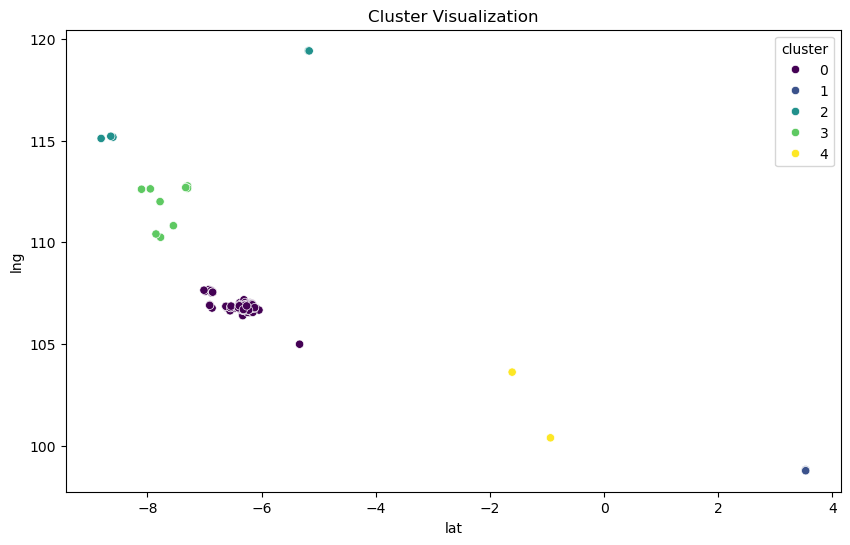

In [15]:
# Visualization cluster menggunakan scater plot
visualize_clusters(
    data=df_od_clean, 
    x_col= 'lat',
    y_col= 'lng', 
    cluster_col="cluster")

In [16]:
# Visualization map berdasarkan cluster dan neighbors
create_cluster_map(
        data = df_od_clean,
       cluster_col = 'cluster', 
       id_col = 'id_order_design', 
       lat_col= 'lat', 
       lng_col= 'lng', 
       neighbors_col = 'neighbors', 
       distances_col = 'valid_distances', 
       address_col= 'address'
                  )

In [18]:
df_od_clean['cluster'] = df_od_clean['cluster'].replace(0, 'Jabodetabek & Sekitarnya')

In [19]:
df_od_clean['cluster'] = df_od_clean['cluster'].replace(1, 'Sumatra Utara & Sekitarnya')

In [20]:
df_od_clean['cluster'] = df_od_clean['cluster'].replace(2, 'Bali & Sekitarnya')

In [21]:
df_od_clean['cluster'] = df_od_clean['cluster'].replace(3, 'Jawa Timur & Yogyakarta')

In [22]:
df_od_clean['cluster'] = df_od_clean['cluster'].replace(4, 'Sumatra Barat & Jambi')

In [24]:
df_od_clean

,id_order_design,id_user,id_designer,code,status_design,address,address_componentable_id,lat,lng,order_date,cluster,neighbors,neighbor_distances,valid_neighbors,valid_distances
0,568,921,949.0,PREBUILD50,in_review,"Emerald View, Jln. Emerald Citra V, Blok D no....",568,-6.28352,106.7110,2024-04-20 15:28:15,Jabodetabek & Sekitarnya,"[674, 641, 568]","[0.0, 0.0, 0.0]","[674, 641, 568]","[0.0, 0.0, 0.0]"
1,569,923,950.0,PREBUILD50,in_review,"Perumahan Jatinegara Indah, Jl Lawu Ujung Blok...",569,-6.19922,106.9270,2024-04-21 10:30:22,Jabodetabek & Sekitarnya,"[569, 663, 839]","[0.0, 0.029463088772227138, 0.03904377543219883]","[569, 663, 839]","[0.0, 3258.7180589049435, 4317.821106738846]"
2,570,925,943.0,PREBUILD50,finish,"Premier Terrace Blok M3, Jalan Raya Ciracas, C...",570,-6.32984,106.8760,2024-04-21 16:00:33,Jabodetabek & Sekitarnya,"[570, 636, 572]","[0.0, 0.03386704740599568, 0.03500180566771175]","[570, 636, 572]","[0.0, 3745.309286065119, 3871.1113548546737]"
3,571,926,946.0,PREBUILD50,in_review,"Mahagoni Park Bintaro Blok B1 No 50, Perigi Ba...",571,-6.26076,106.6900,2024-04-22 10:25:36,Jabodetabek & Sekitarnya,"[571, 865, 646]","[0.0, 0.00457192519623849, 0.008526576100635307]","[571, 865, 646]","[0.0, 505.73972627959273, 943.4743886329433]"
4,572,927,928.0,N/A,finish,Jl. Ujung Gedong RT 002 RW 012 no.69 Kel. Gedo...,572,-6.29776,106.8620,2024-04-22 11:41:42,Jabodetabek & Sekitarnya,"[572, 608, 650]","[0.0, 0.02196235187770273, 0.028981897798445348]","[572, 608, 650]","[0.0, 2430.073915048433, 3206.8064940288273]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,911,1681,931.0,freesurvey,in_review_internal,Bumi Cimanggi Indah Blok A6 no.20 kel.sukatani...,911,-6.38782,106.8760,2024-09-18 16:10:26,Jabodetabek & Sekitarnya,"[911, 633, 825]","[0.0, 0.017283868201295585, 0.021784235125430148]","[911, 633, 825]","[0.0, 1911.839979885359, 2409.763253329865]"
193,912,1641,1301.0,freesurvey,in_review,"BSD City Cluster Sevilla CB17 Serpong, Tangsel...",912,-6.31722,106.6920,2024-09-19 10:38:36,Jabodetabek & Sekitarnya,"[912, 585, 604]","[0.0, 0.0, 0.006415637146854094]","[912, 585, 604]","[0.0, 0.0, 709.7273845895988]"
194,914,1686,982.0,freesurvey,finish,"Jl. Rambutan No.12A CONDET, Kel. Cililitan, Ke...",914,-6.25960,106.8690,2024-09-21 09:44:30,Jabodetabek & Sekitarnya,"[914, 647, 882]","[0.0, 0.017812007186167846, 0.02682237871628497]","[914, 647, 882]","[0.0, 1970.2017314391426, 2967.625455332552]"
195,915,1485,948.0,freesurvey,on_going,"Madirsan,tanjung Morawa, Kabupaten Deli Serdan...",915,3.53093,98.7633,2024-09-21 16:23:20,Sumatra Utara & Sekitarnya,"[918, 915, 810]","[0.0, 0.0, 0.044510139294321904]","[918, 915, 810]","[0.0, 0.0, 4945.4947991578065]"


In [25]:
df_od_clean = df_od_clean.drop(columns=["neighbor_distances"])

In [26]:
df_od_clean.to_csv("result/order_design_clustering_new.csv", index = False )